In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler
import os, glob, inspect, sys
import re

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib_2 as mc
from importlib import reload
reload(mc)


<module 'epri_mc_lib_2' from '/Users/apple/Desktop/s2ds/work_project/Oct20_EPRI/Task2/NB/epri_mc_lib_2.py'>

In [129]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

### Import data and merge replicates

In [92]:
merged = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/MERGE_FT_TEP_UT_on_ID.csv'),
                    index_col=0)
merged.index = merged.index.str.rstrip('-12345')
mean_df = merged.groupby('ID').mean()
# Get rid of cold work
cw_regex = re.compile("[0-9]+$") 
mean_df['cold_work'] = [int(re.search(cw_regex,x).group()) for x in mean_df.index]
mean_df.index = mean_df.index.str.rstrip('02468')
mean_df.index = mean_df.index.str.rstrip('-')

## Select columns of interest

In [93]:
mean_df = mean_df[mc.regression_cols].dropna()

In [94]:
mean_df.index=mean_df.index+"-"+mean_df.cold_work.astype("str")

In [95]:
mean_df.drop(["cold_work"], axis=1, inplace=True)

In [96]:
mean_df=mean_df.iloc[10:15]
mean_df

,KJIC,MS_Avg,TEP_average,Beta_avg,PC_IF_2.25MHz,PC_IF_3.5MHz,PC_BS
347-0,198.50,0.0220,-1.43700,0.002710,0.0,0.0,0.0
347-20,124.06,0.3400,-1.36400,0.001770,195.0,202.0,-25.0
347-40,89.88,1.0115,-1.27925,0.002237,182.0,241.0,-28.0
347-60,77.80,3.1390,-1.10000,0.002429,206.0,287.0,-33.0
347-80,74.00,6.3910,-0.82200,0.002559,206.0,255.0,-39.0


## Scale data

In [97]:
scaled_df = mc.scale_general(mean_df, MinMaxScaler())
scaled_df[0]

,KJIC,MS_Avg,TEP_average,Beta_avg,PC_IF_2.25MHz,PC_IF_3.5MHz,PC_BS
347-0,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
347-20,0.402088,0.049929,0.118699,0.000000,0.946602,0.703833,0.358974
347-40,0.127550,0.155362,0.256504,0.496631,0.883495,0.839721,0.282051
347-60,0.030522,0.489402,0.547967,0.700772,1.000000,1.000000,0.153846
347-80,0.000000,1.000000,1.000000,0.839458,1.000000,0.888502,0.000000


<AxesSubplot:>

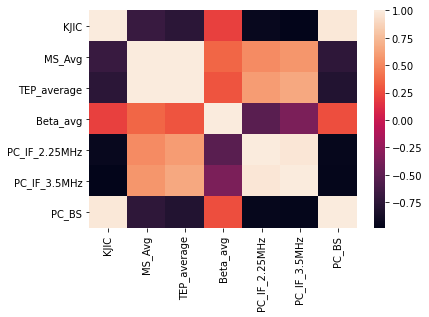

In [98]:
sns.heatmap(mean_df.corr())

In [99]:
# Creating Predictor variable 'X' and Target Variable 'y'

# X contains all the features except for the target value Price
X = scaled_df[0].drop('KJIC', axis = 1)
y = scaled_df[0]['KJIC']

In [100]:
X

,MS_Avg,TEP_average,Beta_avg,PC_IF_2.25MHz,PC_IF_3.5MHz,PC_BS
347-0,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
347-20,0.049929,0.118699,0.000000,0.946602,0.703833,0.358974
347-40,0.155362,0.256504,0.496631,0.883495,0.839721,0.282051
347-60,0.489402,0.547967,0.700772,1.000000,1.000000,0.153846
347-80,1.000000,1.000000,0.839458,1.000000,0.888502,0.000000


In [101]:
from sklearn.model_selection import train_test_split

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=50)

# X_train contains 70% of total dataset
print(y_train.shape)
# X_test contains 30% of total dataset
print(X_test.shape)

(3,)
(2, 6)


## Linear Regression

In [103]:
from sklearn.linear_model import LinearRegression

In [104]:
lr = LinearRegression()

In [105]:
#Train/fit the model to training data
lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [106]:
# print the intercept
print(lr.intercept_)

#Coefficients
coeff_df = pd.DataFrame(lr.coef_,X.columns,columns=['Coefficient'])
coeff_df

0.7102639755250164


,Coefficient
MS_Avg,-0.185028
TEP_average,-0.188286
Beta_avg,0.076703
PC_IF_2.25MHz,-0.227511
PC_IF_3.5MHz,-0.195642
PC_BS,0.213033


In [107]:
pred = lr.predict(X_test)

Text(0, 0.5, 'Predicted Fracture Toughness')

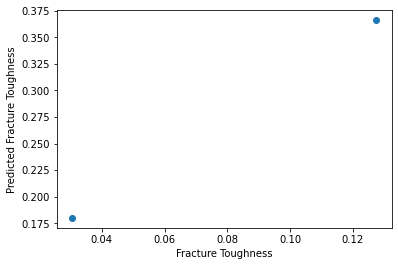

In [108]:
plt.scatter(y_test,pred)
plt.xlabel("Fracture Toughness")
plt.ylabel("Predicted Fracture Toughness")

In [109]:
from sklearn import metrics

In [110]:
print('MAE:', metrics.mean_absolute_error(y_test, pred))
print('MSE:', metrics.mean_squared_error(y_test, pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

MAE: 0.19397428629185237
MSE: 0.03961403308269518
RMSE: 0.19903274374508123


## Lasso

In [111]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha=0.5)
reg.fit(X_train, y_train)

Lasso(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [112]:
print('Lasso Regression: R^2 score on training set', reg.score(X_train, y_train)*100)
print('Lasso Regression: R^2 score on test set', reg.score(X_test, y_test)*100)

Lasso Regression: R^2 score on training set 0.0
Lasso Regression: R^2 score on test set -6407.065966892279


In [113]:
# Lasso with different lambdas
lambdas = (0.001, 0.01, 0.1, 0.5, 1, 2, 10)
l_num = 7
pred_num = X.shape[1]

# prepare data for enumerate
coeff_a = np.zeros((l_num, pred_num))
train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)

In [114]:
# enumerate through lambdas with index and i
for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i)
    reg.fit(X_train, y_train)
       
    coeff_a[ind,:] = reg.coef_
    train_r_squared[ind] = reg.score(X_train, y_train)
    test_r_squared[ind] = reg.score(X_test, y_test)

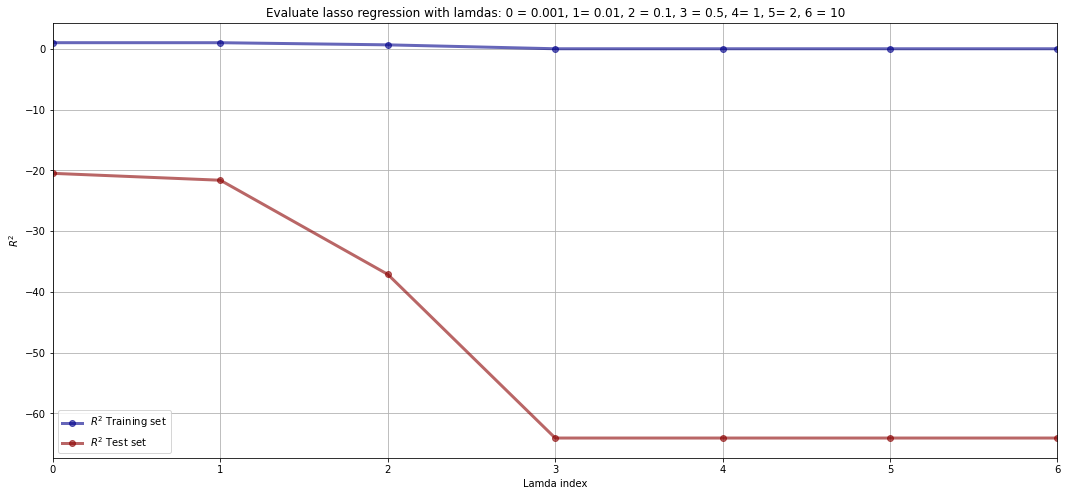

In [115]:
# Plotting
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda index'); plt.ylabel(r'$R^2$')
plt.xlim(0, 6)
plt.title(r'Evaluate lasso regression with lamdas: 0 = 0.001, 1= 0.01, 2 = 0.1, 3 = 0.5, 4= 1, 5= 2, 6 = 10')
plt.legend(loc='best')
plt.grid()

In [116]:
# Identifying the best lambda
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared   -2050.655198
lambda          0.001000
Name: 0, dtype: float64

In [117]:
# Coefficients of best model
reg_best = Lasso(alpha = 0.1)
reg_best.fit(X_train, y_train)
reg_best.coef_

array([-0.06570847, -0.02635202,  0.        , -0.30794269, -0.        ,
        0.        ])

In [118]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, reg_best.predict(X_test))

0.08975494165066791

In [119]:
# Cross Validation
l_min = 0.05
l_max = 0.2
l_num = 20
lambdas = np.linspace(l_min,l_max, l_num)

train_r_squared = np.zeros(l_num)
test_r_squared = np.zeros(l_num)

pred_num = X.shape[1]
coeff_a = np.zeros((l_num, pred_num))

In [120]:
from sklearn.model_selection import cross_val_score

for ind, i in enumerate(lambdas):    
    reg = Lasso(alpha = i)
    reg.fit(X_train, y_train)
    results = cross_val_score(reg, X, y, cv=5, scoring="r2") 

    train_r_squared[ind] = reg.score(X_train, y_train)    
    test_r_squared[ind] = reg.score(X_test, y_test)

/opt/anaconda3/envs/epri/lib/python3.8/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/epri/lib/python3.8/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/epri/lib/python3.8/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/epri/lib/python3.8/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/epri/lib/python3.8/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-d

/opt/anaconda3/envs/epri/lib/python3.8/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/epri/lib/python3.8/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/epri/lib/python3.8/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/epri/lib/python3.8/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/opt/anaconda3/envs/epri/lib/python3.8/site-packages/sklearn/metrics/_regression.py:582: UndefinedMetricWarning: R^2 score is not well-d

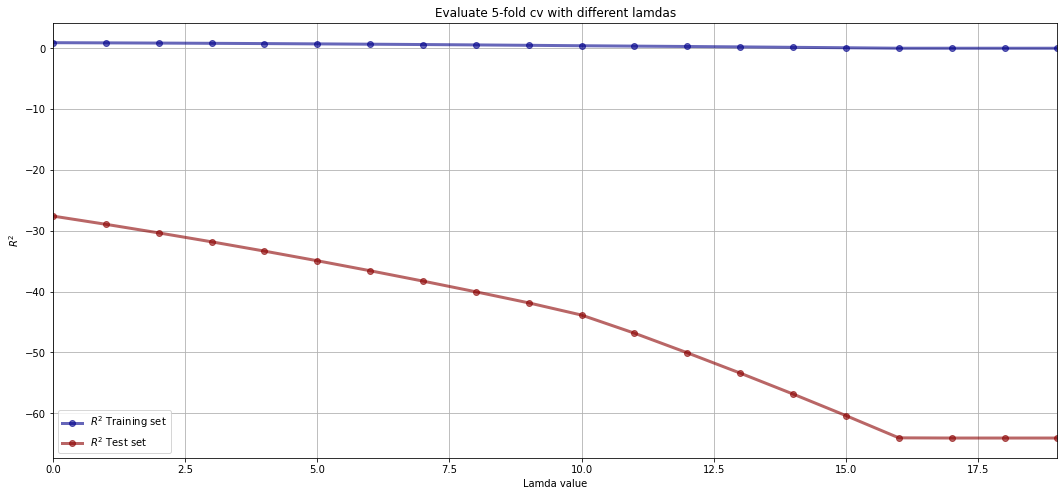

In [121]:
# Plotting
plt.figure(figsize=(18, 8))
plt.plot(train_r_squared, 'bo-', label=r'$R^2$ Training set', color="darkblue", alpha=0.6, linewidth=3)
plt.plot(test_r_squared, 'bo-', label=r'$R^2$ Test set', color="darkred", alpha=0.6, linewidth=3)
plt.xlabel('Lamda value'); plt.ylabel(r'$R^2$')
plt.xlim(0, 19)
plt.title(r'Evaluate 5-fold cv with different lamdas')
plt.legend(loc='best')
plt.grid()

In [122]:
# Best Model
df_lam = pd.DataFrame(test_r_squared*100, columns=['R_squared'])
df_lam['lambda'] = (lambdas)
# returns the index of the row where column has maximum value.
df_lam.loc[df_lam['R_squared'].idxmax()]

R_squared   -2758.898775
lambda          0.050000
Name: 0, dtype: float64

In [123]:
# Best Model
reg_best = Lasso(alpha = 5.0)
reg_best.fit(X_train, y_train)

Lasso(alpha=5.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [124]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, reg_best.predict(X_test))

0.1531511929019065

In [125]:
reg_best.coef_

array([-0., -0.,  0., -0., -0.,  0.])

Text(0, 0.5, 'Predicted Fracture Toughness')

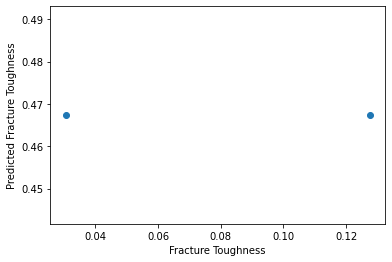

In [126]:
pred1 = reg_best.predict(X_test)
plt.scatter(y_test,pred1)
plt.xlabel("Fracture Toughness")
plt.ylabel("Predicted Fracture Toughness")

In [127]:
pred1

array([0.46736278, 0.46736278])

## Ridge Regression

In [131]:
# Ridge Regression
rr = Ridge(alpha=0.01)
rr.fit(X_train, y_train) 
pred_train_rr= rr.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rr)))
print(r2_score(y_train, pred_train_rr))

pred_test_rr= rr.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
print(r2_score(y_test, pred_test_rr))

0.0017105398312189843
0.9999826658899137
0.19978545256590688
-15.958699671607302


Text(0, 0.5, 'Predicted Fracture Toughness')

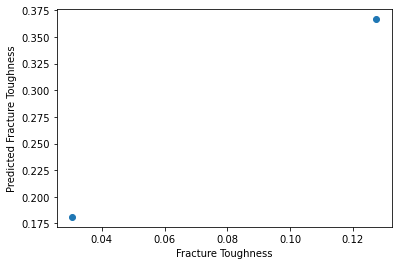

In [132]:
plt.scatter(y_test,pred_test_rr)
plt.xlabel("Fracture Toughness")
plt.ylabel("Predicted Fracture Toughness")

## Elastic net

In [130]:
#Elastic Net
model_enet = ElasticNet(alpha = 0.01)
model_enet.fit(X_train, y_train) 
pred_train_enet= model_enet.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_enet)))
print(r2_score(y_train, pred_train_enet))

pred_test_enet= model_enet.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_enet)))
print(r2_score(y_test, pred_test_enet))

0.015126164012851925
0.9986445210498378
0.18883386872220462
-14.150417722761969


Text(0, 0.5, 'Predicted Fracture Toughness')

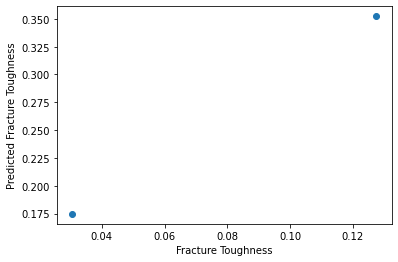

In [133]:
plt.scatter(y_test,pred_test_enet)
plt.xlabel("Fracture Toughness")
plt.ylabel("Predicted Fracture Toughness")